### Test of xhistogram vs MOM5 binning using snapshots

In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
import numpy as np
import pandas as pd
import cftime
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os
import warnings
warnings.simplefilter("ignore")
from dask.distributed import Client

from xhistogram.xarray import histogram


In [2]:
client = Client(n_workers=8)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/40673/status,
Dashboard: /proxy/40673/status,Workers: 8
Total threads: 16,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34363,Workers: 8
Dashboard: /proxy/40673/status,Total threads: 16
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:43147,Total threads: 2
Dashboard: /proxy/35825/status,Memory: 31.25 GiB
Nanny: tcp://127.0.0.1:38479,


In [3]:
# files:
base = '/scratch/e14/cy8964/access-om2/archive/025deg_jra55_ryf/';
xch = 1440#2*288
ych = 1080#2*216

fgrd   = xr.open_dataset(base + 'output096/ocean/ocean_grid.nc').chunk({'yt_ocean':ych,'yu_ocean':ych,'xt_ocean':xch,'xu_ocean':xch})
fwmass_mean = xr.open_mfdataset('/scratch/e14/cy8964/temp/025deg_096/ocean_wmass_mean.nc').chunk({'grid_yt_ocean':ych,'grid_yu_ocean':ych,'grid_xt_ocean':xch})
fmonth_mean = xr.open_mfdataset('/scratch/e14/cy8964/temp/025deg_096/ocean_month_mean.nc').chunk({'yt_ocean':ych,'yu_ocean':ych,'xt_ocean':xch})
fheat_mean = xr.open_mfdataset('/scratch/e14/cy8964/temp/025deg_096/ocean_heat_mean.nc').chunk({'yt_ocean':ych,'xt_ocean':xch})

# load RYF daily data
base_msc = '/scratch/e14/cy8964/access-om2/archive/025deg_jra55_ryf/'
# ---------------------------------------------------------------------------------- #
# load in data set ----------------------------------------------------------------- #
fdaily = xr.open_mfdataset(base_msc+'output098/ocean/ocean_daily.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fheat_daily = xr.open_mfdataset(base_msc+'output098/ocean/ocean_heat_daily.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fwmass_daily = xr.open_mfdataset(base_msc+'output098/ocean/ocean_wmass_daily.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'grid_yt_ocean':ych/10,'grid_xt_ocean':xch/10})

# ---------------------------------------------------------------------------------- #

# Generate xgcm grid object:
gridwm = Grid(fwmass_daily,coords={"x":{"center":"grid_xt_ocean"},
                             "y":{"center":"grid_yt_ocean","right":"grid_yu_ocean"},
                             "T":{"center":"neutral","outer":"neutralrho_edges"}},periodic=False)
gridmn = Grid(fdaily,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean","right":"yu_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)
gridht = Grid(fheat_daily,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)
# ---------------------------------------------------------------------------------- #

# Some constants:
Cp = 3992.10322329649
rho0 = 1035
dT = (fwmass_daily.neutral[1]-fwmass_daily.neutral[0]).values

sc_daylength = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

area = fgrd.area_t.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
dy = gridmn.diff(fgrd.yu_ocean,'y',boundary='extend').rename({'yt_ocean':'grid_yt_ocean'})

In [4]:
tbins = fwmass_daily.neutralrho_edges.values

In [5]:
temp_u_daily = gridmn.interp(fdaily.temp,'y',boundary='extend')-273.15
temp_u_daily2 = fdaily.temp.interp({'yt_ocean':fdaily.yu_ocean})-273.15


In [23]:
# temperature binning of 1daily
temp_u_daily = gridmn.interp(fdaily.temp,'y',boundary='extend')-273.15
#temp_u_daily = gridd.interp(temp_u_daily,'z', boundary='extend')
#fdaily_edge = gridd.interp(fdaily.ty_trans,'z', boundary='extend')
fwmass_daily["ty_trans_nrho_mean_1day"] = histogram(temp_u_daily, bins=[tbins], dim = ['st_ocean'],weights=fdaily.ty_trans).rename({temp_u_daily.name+'_bin':'neutral','xt_ocean':'grid_xt_ocean','yu_ocean':'grid_yu_ocean'})
Psi_mean_1day = gridwm.cumsum(fwmass_daily.ty_trans_nrho_mean_1day.sum('grid_xt_ocean'), 'T',boundary="fill", fill_value=0)/rho0


In [6]:
# temperature binning of 1daily
temp_u_daily = gridmn.interp(fdaily.temp,'y',boundary='extend')-273.15
fwmass_daily["ty_trans_nrho_mean_1day_xgcm"] = gridmn.transform(fdaily.ty_trans,'z',fwmass_daily.neutralrho_edges,method='conservative',target_data=temp_u_daily).rename({'neutralrho_edges':'neutral','xt_ocean':'grid_xt_ocean','yu_ocean':'grid_yu_ocean'})
Psi_mean_1day_xgcm = gridwm.cumsum(fwmass_daily.ty_trans_nrho_mean_1day_xgcm.sum('grid_xt_ocean'), 'T',boundary="fill", fill_value=0)/rho0


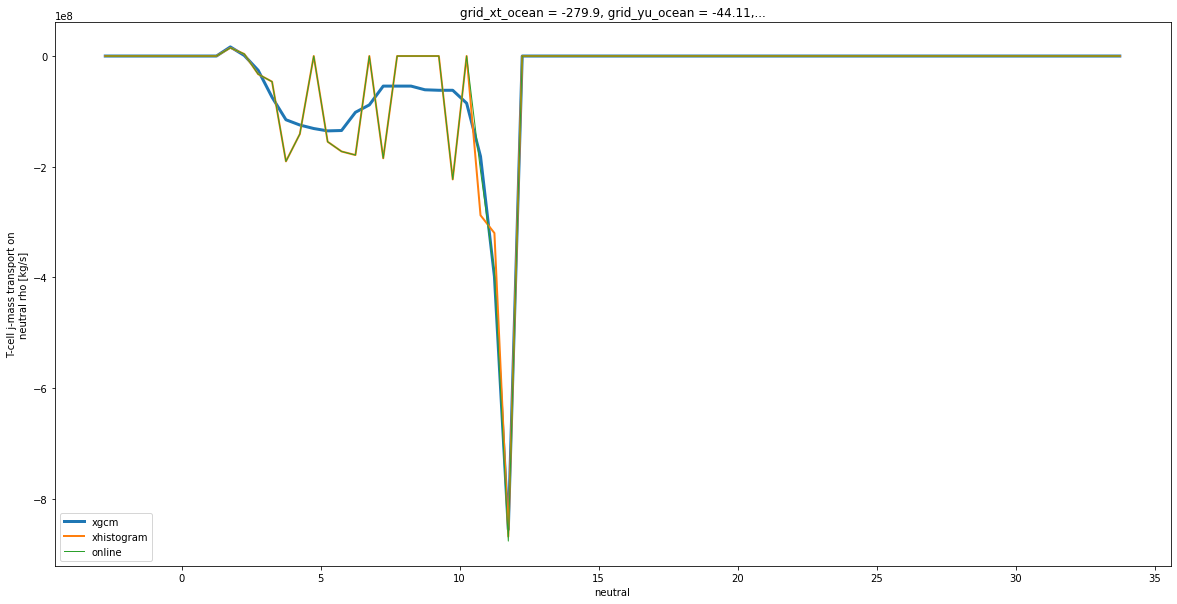

In [7]:
plt.figure(figsize = (20,10))

x = 0
y = 300
fwmass_daily.ty_trans_nrho_mean_1day_xgcm.isel(grid_xt_ocean = x).isel(grid_yu_ocean = y).plot(label = 'xgcm', linewidth = 3)
fwmass_daily.ty_trans_nrho_mean_1day.isel(grid_xt_ocean = x).isel(grid_yu_ocean = y).plot(label = 'xhistogram', linewidth = 2)
fwmass_daily.ty_trans_nrho.isel(grid_xt_ocean = x).isel(grid_yu_ocean = y).plot(label = 'online', linewidth = 1)
plt.legend()


### Using snapshots

In [8]:
fsnap = xr.open_mfdataset(base_msc+'output098/ocean/ocean_snap.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fwmass_snap = xr.open_mfdataset(base_msc+'output098/ocean/ocean_wmass_snap.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'grid_yt_ocean':ych/10,'grid_xt_ocean':xch/10})


In [9]:
# temperature binning of 1daily
temp_u_daily = gridmn.interp(fsnap.temp,'y',boundary='extend')-273.15
#temp_u_daily = gridd.interp(temp_u_daily,'z', boundary='extend')
#fdaily_edge = gridd.interp(fdaily.ty_trans,'z', boundary='extend')
fwmass_snap["ty_trans_nrho_mean_1day"] = histogram(temp_u_daily, bins=[tbins], dim = ['st_ocean'],weights=fsnap.ty_trans).rename({temp_u_daily.name+'_bin':'neutral','xt_ocean':'grid_xt_ocean','yu_ocean':'grid_yu_ocean'})
Psi_mean_1day = gridwm.cumsum(fwmass_snap.ty_trans_nrho_mean_1day.sum('grid_xt_ocean'), 'T',boundary="fill", fill_value=0)/rho0


In [10]:
# temperature binning of 1daily
temp_u_daily = gridmn.interp(fsnap.temp,'y',boundary='extend')-273.15
fwmass_snap["ty_trans_nrho_mean_1day_xgcm"] = gridmn.transform(fsnap.ty_trans,'z',fwmass_snap.neutralrho_edges,method='conservative',target_data=temp_u_daily).rename({'neutralrho_edges':'neutral','xt_ocean':'grid_xt_ocean','yu_ocean':'grid_yu_ocean'})
Psi_mean_1day_xgcm = gridwm.cumsum(fwmass_snap.ty_trans_nrho_mean_1day_xgcm.sum('grid_xt_ocean'), 'T',boundary="fill", fill_value=0)/rho0


In [11]:
fwmass_snap.ty_trans_nrho

<xarray.DataArray 'ty_trans_nrho' (time: 1, neutral: 74, grid_yu_ocean: 1080,
                                   grid_xt_ocean: 1440)>
dask.array<rechunk-merge, shape=(1, 74, 1080, 1440), dtype=float64, chunksize=(1, 74, 1080, 144), chunktype=numpy.ndarray>
Coordinates:
  * grid_xt_ocean  (grid_xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.62 79.88
  * grid_yu_ocean  (grid_yu_ocean) float64 -81.02 -80.92 -80.81 ... 89.89 90.0
  * neutral        (neutral) float64 -2.75 -2.25 -1.75 ... 32.75 33.25 33.75
  * time           (time) object 2082-01-12 00:00:00
Attributes:
    long_name:     T-cell j-mass transport on neutral rho
    units:         kg/s
    valid_range:   [-1.e+20  1.e+20]
    cell_methods:  time: point

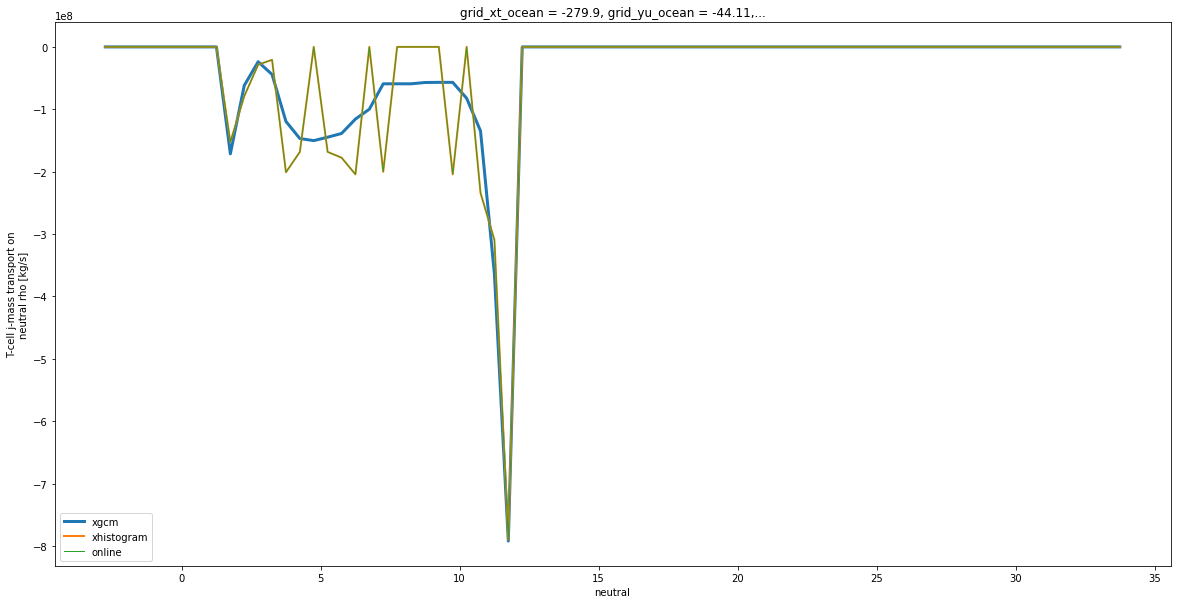

In [12]:
plt.figure(figsize = (20,10))

x = 0
y = 300
fwmass_snap.ty_trans_nrho_mean_1day_xgcm.isel(grid_xt_ocean = x).isel(grid_yu_ocean = y).plot(label = 'xgcm', linewidth = 3)
fwmass_snap.ty_trans_nrho_mean_1day.isel(grid_xt_ocean = x).isel(grid_yu_ocean = y).plot(label = 'xhistogram', linewidth = 2)
fwmass_snap.ty_trans_nrho.isel(grid_xt_ocean = x).isel(grid_yu_ocean = y).plot(label = 'online', linewidth = 1)
plt.legend()


In [13]:
fwmass_snap.ty_trans_nrho_mean_1day.isel(grid_xt_ocean = x).isel(grid_yu_ocean = y).values

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.52577310e+08, -7.89636391e+07, -2.85067351e+07,
        -2.07248073e+07, -2.00972660e+08, -1.68421616e+08,
         0.00000000e+00, -1.68358867e+08, -1.77548877e+08,
        -2.04347242e+08,  0.00000000e+00, -2.00178418e+08,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -2.04291251e+08,  0.00000000e+00,
        -2.34086526e+08, -3.09366053e+08, -7.90213689e+08,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+0

In [14]:
fwmass_snap.ty_trans_nrho.isel(grid_xt_ocean = x).isel(grid_yu_ocean = y).values

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.52577310e+08, -7.89636391e+07, -2.85067351e+07,
        -2.07248073e+07, -2.00972660e+08, -1.68421616e+08,
         0.00000000e+00, -1.68358867e+08, -1.77548877e+08,
        -2.04347242e+08,  0.00000000e+00, -2.00178418e+08,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -2.04291251e+08,  0.00000000e+00,
        -2.34086526e+08, -3.09366053e+08, -7.90213689e+08,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+0

Interpolation of temperature from u to t cells might be off (xgcm does linear, but cell dyt varies)

### And for temp_vdiffuse_diff_cbt

In [18]:
fwmass_snap["temp_vdiffuse_diff_cbt_mean_1day"] = histogram(fsnap.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fsnap.temp_vdiffuse_diff_cbt).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_snap["temp_vdiffuse_diff_cbt_mean_1day_xgcm"] = gridmn.transform(fsnap.temp_vdiffuse_diff_cbt,'z',fwmass_snap.neutralrho_edges,method='conservative',target_data=fsnap.temp-273.15).rename({'neutralrho_edges':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})


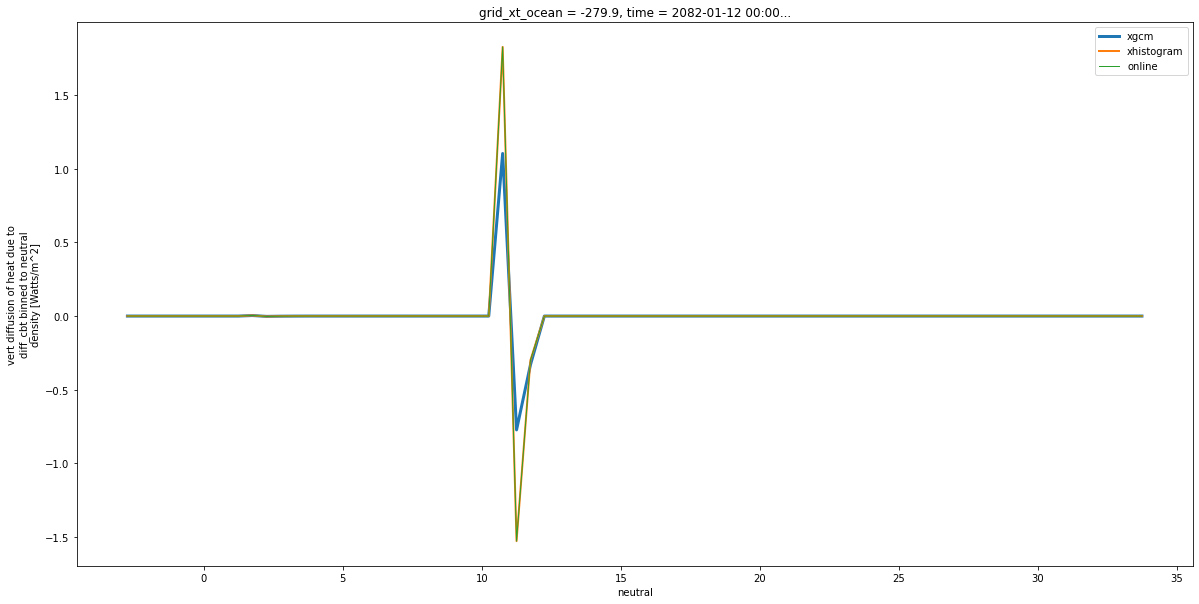

In [20]:
plt.figure(figsize = (20,10))

x = 0
y = 300
fwmass_snap.temp_vdiffuse_diff_cbt_mean_1day_xgcm.isel(grid_xt_ocean = x).isel(grid_yt_ocean = y).plot(label = 'xgcm', linewidth = 3)
fwmass_snap.temp_vdiffuse_diff_cbt_mean_1day.isel(grid_xt_ocean = x).isel(grid_yt_ocean = y).plot(label = 'xhistogram', linewidth = 2)
fwmass_snap.temp_vdiffuse_diff_cbt_on_nrho.isel(grid_xt_ocean = x).isel(grid_yt_ocean = y).plot(label = 'online', linewidth = 1)
plt.legend()


In [21]:
fwmass_snap.temp_vdiffuse_diff_cbt_mean_1day.isel(grid_xt_ocean = x).isel(grid_yt_ocean = y).values

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         4.37499467e-03, -2.79295722e-03, -1.07200279e-03,
        -2.32885092e-04, -9.56058057e-05, -3.23411952e-05,
         0.00000000e+00, -5.22308843e-05, -2.22565434e-05,
        -1.10341173e-05,  0.00000000e+00,  6.58670352e-05,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -3.34963984e-05,  0.00000000e+00,  0.00000000e+00,
         1.82692728e+00, -1.52742735e+00, -2.99595985e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+0

In [22]:
fwmass_snap.temp_vdiffuse_diff_cbt_on_nrho.isel(grid_xt_ocean = x).isel(grid_yt_ocean = y).values

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         4.37499467e-03, -2.79295722e-03, -1.07200279e-03,
        -2.32885092e-04, -9.56058057e-05, -3.23411952e-05,
         0.00000000e+00, -5.22308843e-05, -2.22565434e-05,
        -1.10341173e-05,  0.00000000e+00,  6.58670352e-05,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -3.34963984e-05,  0.00000000e+00,  0.00000000e+00,
         1.82692728e+00, -1.52742735e+00, -2.99595985e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+0

# Looks good. Check whole globe:

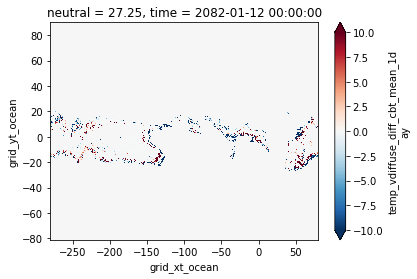

In [27]:
fwmass_snap.temp_vdiffuse_diff_cbt_mean_1day.isel(neutral = 60).plot(vmax = 10)

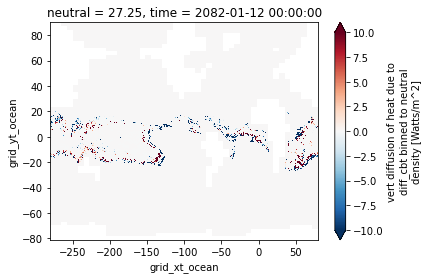

In [26]:
fwmass_snap.temp_vdiffuse_diff_cbt_on_nrho.isel(neutral = 60).plot(vmax = 10)

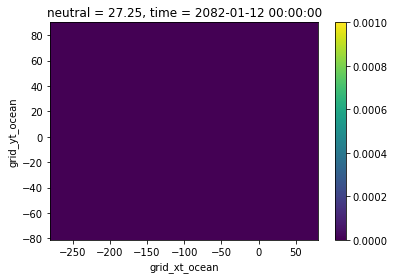

2022-05-09 17:35:28,747 - distributed.nanny - WARNING - Restarting worker
2022-05-09 17:35:28,856 - distributed.nanny - WARNING - Restarting worker
2022-05-09 17:35:28,913 - distributed.nanny - WARNING - Restarting worker
2022-05-09 17:35:28,952 - distributed.nanny - WARNING - Restarting worker
2022-05-09 17:35:28,961 - distributed.nanny - WARNING - Restarting worker
2022-05-09 17:35:29,081 - distributed.nanny - WARNING - Restarting worker
2022-05-09 17:35:29,083 - distributed.nanny - WARNING - Restarting worker
2022-05-09 17:35:29,088 - distributed.nanny - WARNING - Restarting worker
2022-05-09 17:35:29,136 - distributed.nanny - WARNING - Restarting worker
2022-05-09 17:35:29,152 - distributed.nanny - WARNING - Restarting worker
2022-05-09 17:35:29,216 - distributed.nanny - WARNING - Restarting worker
2022-05-09 17:35:29,247 - distributed.nanny - WARNING - Restarting worker
2022-05-09 17:35:30,044 - distributed.nanny - WARNING - Restarting worker
2022-05-09 17:35:30,046 - distributed.

In [30]:
(fwmass_snap.temp_vdiffuse_diff_cbt_on_nrho.isel(neutral = 60)-fwmass_snap.temp_vdiffuse_diff_cbt_mean_1day.isel(neutral = 60)).fillna(0).plot(vmax = 0.001)